# 卷积神经网络

## 从全连接到卷积

想象一张100万像素的图片，输入特征则是100万维，即使隐藏层单元为100，从100万降到100维，期间的权重参数达到100万x100级别，运算非常大。

### 不变性

- 平移不变性：同一个物体，处于图片的不同位置，应该都能能被识别（识别器是相同的）
- 局部性：只需要观察部分像素，而不是整张图片

### 重新考察全连接层

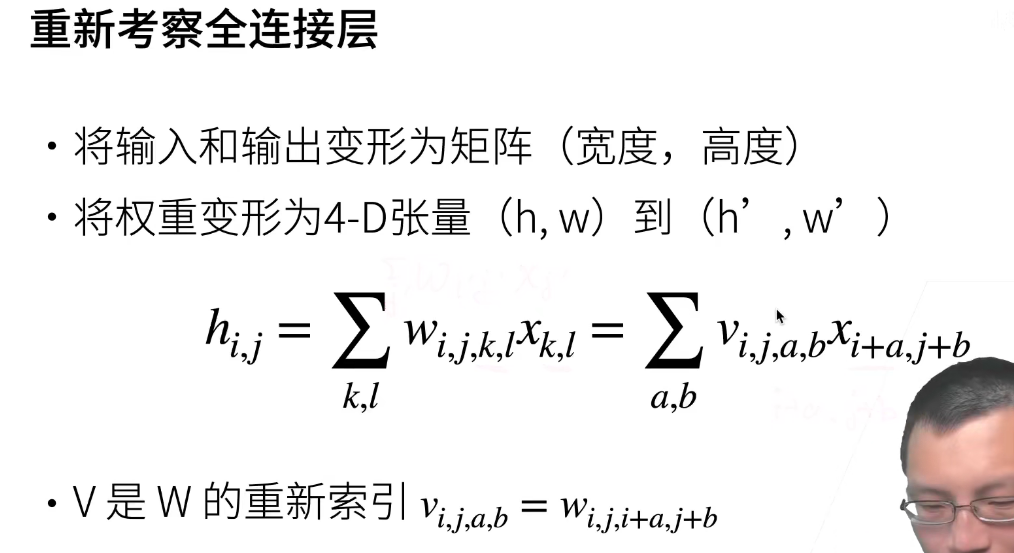

- 将一维的输入写成二维

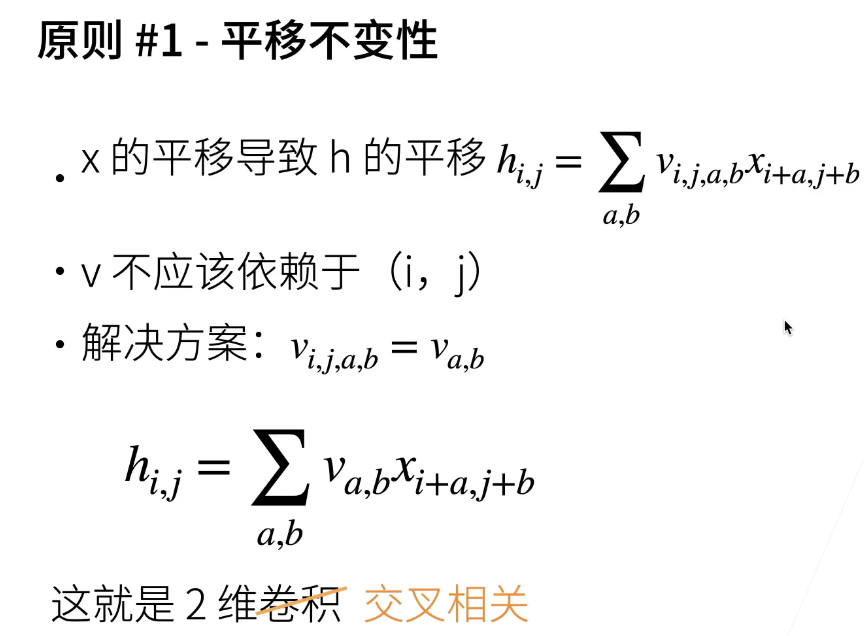

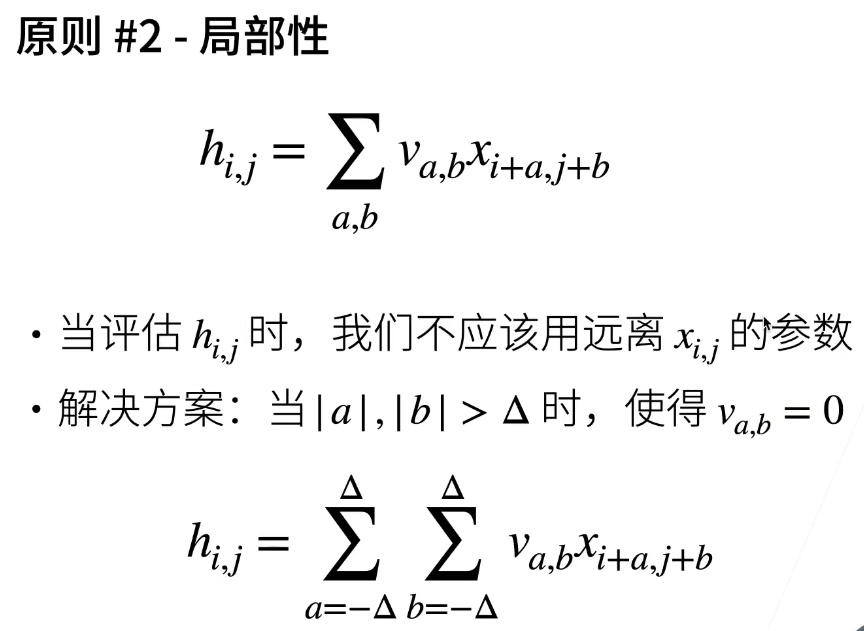

### 卷积

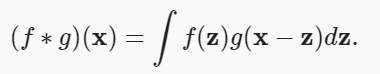

卷积：测量两个函数f和g（其中一个函数“翻转”并平移x）之间的重叠。

参考链接：https://www.bilibili.com/video/BV1VV411478E?from=search&seid=1725700777641154181

## 图像卷积

### 互相关运算

In [1]:
# 二维互相关运算
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):  #@save
    # hxw
    h,w = K.shape
    Y = torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1),dtype=torch.float32)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h,j:j+w]*K).sum()
    return Y

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 卷积层

作用：特征映射。

感受野：输出19的感受野是0 1 3 4四个输入。

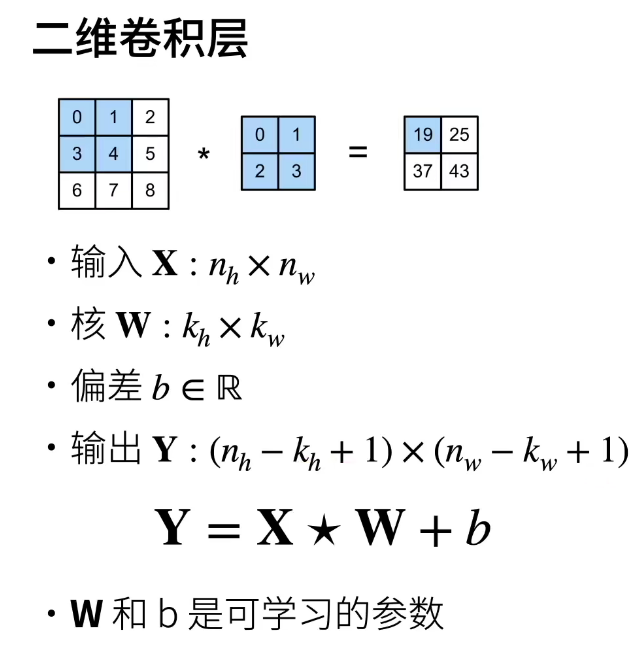

In [3]:
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size)) # kernel_size: (2,3)
        self.bias = nn.Parameter(torch.zeros(1))
    def forward(self,x):
        return corr2d(x,self.weight)+self.bias

### 图像中目标的边缘检测

In [24]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [25]:
# 构造一个高度为 1 、宽度为 2 的卷积核K。当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零
K = torch.tensor([[1.0, -1.0]])

In [26]:
y = corr2d(X, K)
y.shape

torch.Size([6, 7])

In [29]:
y

tensor([[[[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
          [ 0.,  1.,  0.,  0.,  0., -1.,  0.]]]])

如上所示，输出y中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘，其他情况的输出为 0 。

### 学习卷积核

In [30]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

conv2d = nn.Conv2d(1,1,kernel_size=(1, 2),bias=False)

#  这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度）
X = X.reshape((1, 1, 6, 8))
y = y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    y_hat = conv2d(X)
    l = (y-y_hat)**2
    conv2d.zero_grad()
    l.sum().backward()
    #迭代卷积核
    conv2d.weight.data[:] -= lr*conv2d.weight.grad 
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1},loss {l.sum():.3f}')

epoch2,loss4.370
epoch4,loss1.021
epoch6,loss0.289
epoch8,loss0.097
epoch10,loss0.036


In [31]:
conv2d.weight.data.reshape((1, 2)) # 非常接近之前定义的卷积核[1.0, -1.0]

tensor([[ 0.9718, -1.0096]])

### 互相关和卷积

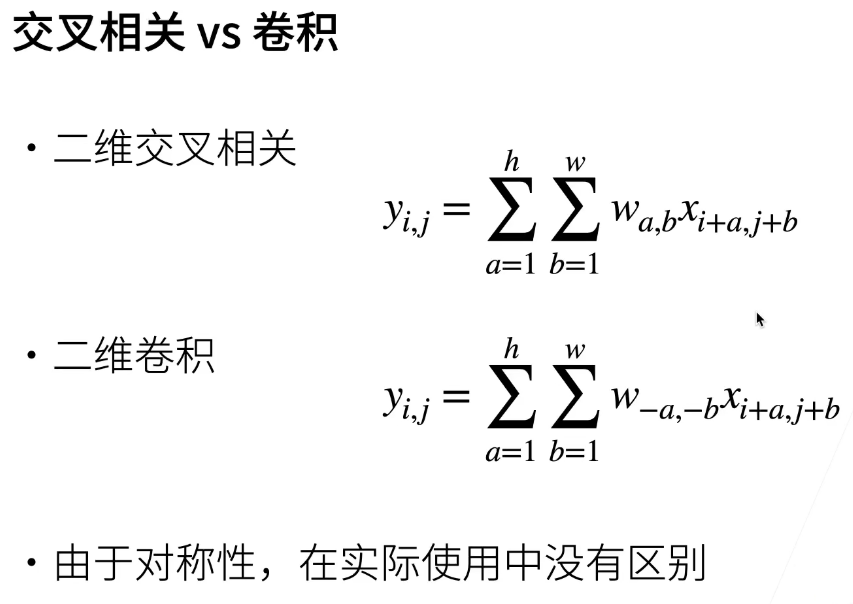

## 卷积里的填充和步幅

### 填充

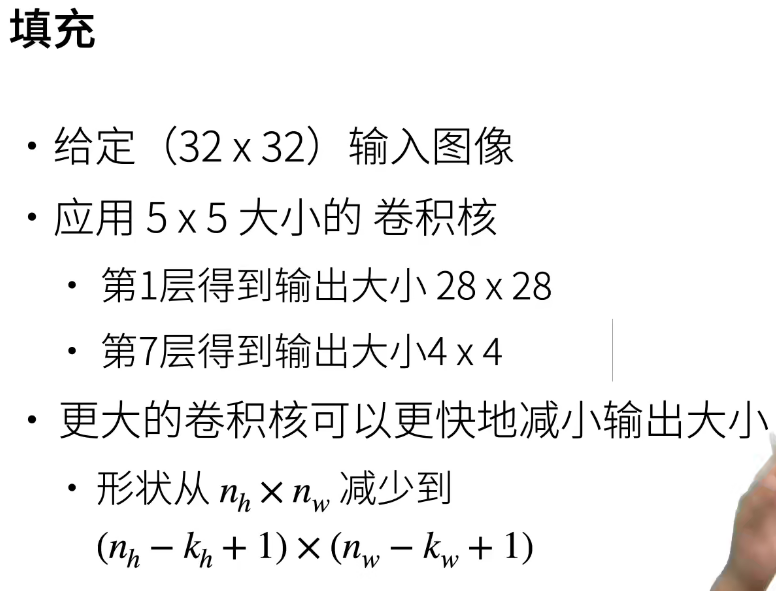

上述这个例子，当卷积层达到7层就不能在加深了，为了使用更深的网络，需要其他技巧。

并且，不断卷积也会让原始图像的边界丢失了许多有用信息。

而填充是解决此问题最有效的方法。

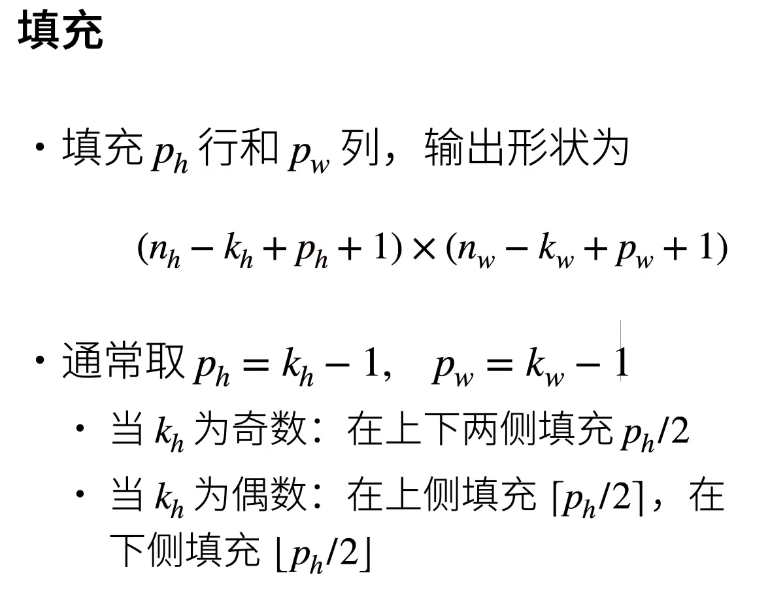

> 通常情况下的取值可以让图片卷积后保持大小不变。

In [32]:
import torch
from torch import nn

def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1,1)+X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# # 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1)
X = torch.rand(size=(8, 8)) # 8-3+1+2
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [33]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1)) # 高度和宽度两边的填充分别为2和1。
comp_conv2d(conv2d, X).shape # 8-5+1+4；8-3+1+2；

torch.Size([8, 8])

### 步幅 

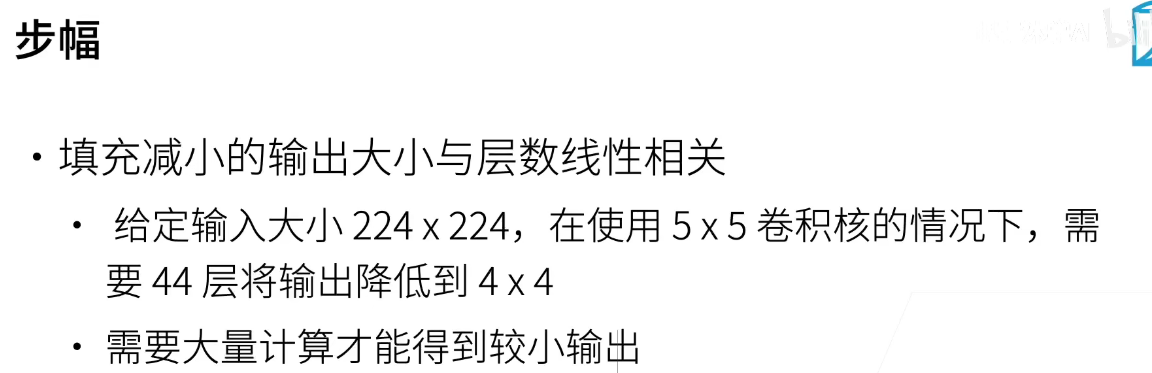

In [34]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [35]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape
# (8-3+0+3)/3 = 2 ; (8-5+2+4)/4 = 2

torch.Size([2, 2])

## 多输入多通道

### 多输入通道

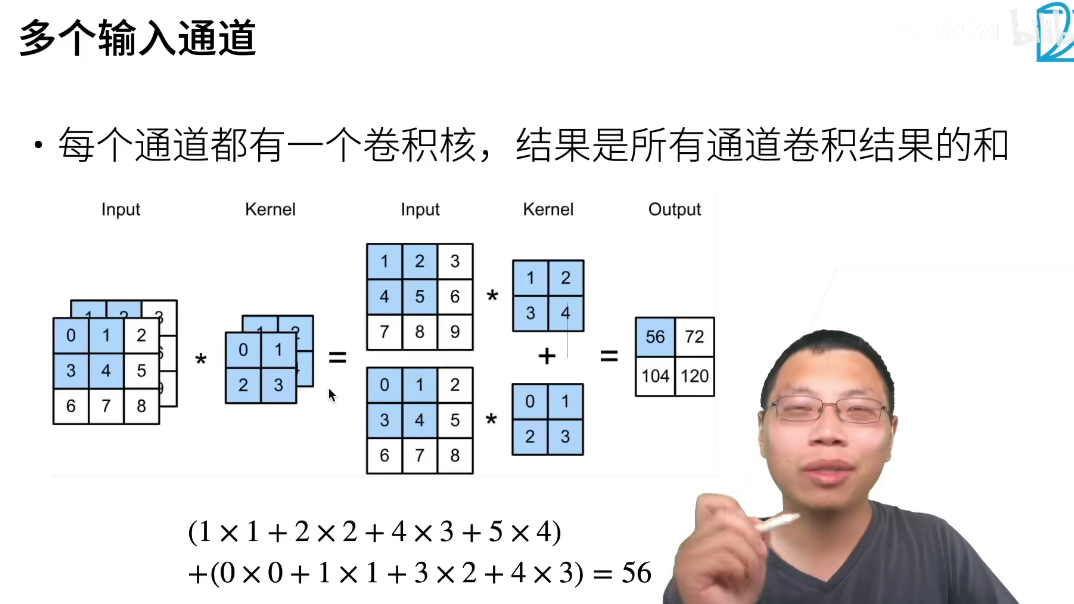

In [36]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    # K是三维张量
    return sum(d2l.corr2d(x, k) for x,k in zip(X,K)) # 不考虑偏置，把一个通道卷积的结果相加

In [37]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 多输出通道

用 ci 和 co 分别表示输入和输出通道的数目，并让 kh 和 kw 为卷积核的高度和宽度。为了获得多个通道的输出，我们可以为每个输出通道创建一个形状为 ci×kh×kw 的卷积核张量，这样卷积核的形状是 co×ci×kh×kw 。在互相关运算中，每个输出通道先获取所有输入通道，再以对应该输出通道的卷积核计算出结果。

多输出通道识别不同模式。

多输入通道组合不同模式。

In [38]:
def corr2d_multi_in_out(X, K):
    # K是四维张量，第0维表示输出通道数
    return torch.stack([corr2d_multi_in(X,k) for k in K],0)

In [39]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [40]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 1x1卷积 

不识别空间模式，因为一次只看一个像素，仅仅为了融合通道。

![](https://zh-v2.d2l.ai/_images/conv-1x1.svg)

特殊的卷积层，也看看成一个全连接层。

In [42]:
def corr2d_multi_in_out_1x1(X, K):
    c_i,h,w = X.shape
    c_o = K.shape[0]
    X = X.reshape(c_i,h*w)
    K = K.reshape(c_o,c_i) # 改变了通道的维度
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K,X)
    return Y.reshape((c_o,h,w))

In [43]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

### 二维卷积时间复杂度分析

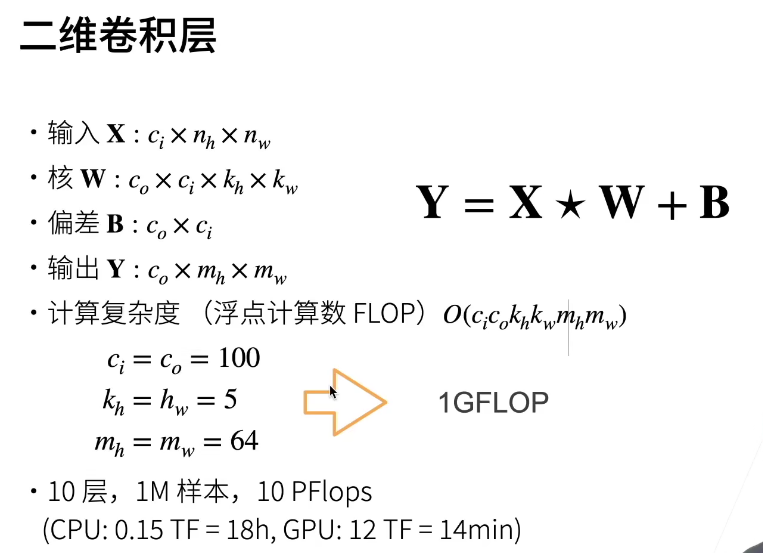